# How to plot transect

Example is for fesom, but with some minimal adjustments should work for any unstryctured or structured meshes.

In [4]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
import intake
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import sys
from pathlib import Path
sys.path.append("../../")
import nereus as nr

Open catalog and data

In [5]:
run_folder = Path("/work/bm1344/k203123/experiments/erc1011/run_20080101T000000-20080131T235845/")

data_atm = xr.open_dataset(run_folder / "erc1011_atm_ml_1d_mean_1_20080103T000000Z.nc")
data_oce = xr.open_dataset(run_folder / "erc1011_oce_ml_1d_mean_20080102T000000Z.nc")

def prep_data(ds):
    ds = ds.rename({"ncells": "cell"})
    return ds

data = prep_data(data_oce)
data

<xarray.Dataset>
Dimensions:  (time: 1, depth: 72, depth_2: 73, cell: 14886338)
Coordinates:
  * time     (time) datetime64[ns] 2008-01-02
  * depth    (depth) float64 1.0 3.1 5.45 8.1 ... 5.279e+03 5.546e+03 5.816e+03
  * depth_2  (depth_2) float64 0.0 2.0 4.2 6.7 ... 5.412e+03 5.681e+03 5.951e+03
Dimensions without coordinates: cell
Data variables:
    to       (time, depth, cell) float32 ...
    so       (time, depth, cell) float32 ...
    u        (time, depth, cell) float32 ...
    v        (time, depth, cell) float32 ...
    w        (time, depth_2, cell) float32 ...
Attributes:
    CDI:                  Climate Data Interface version 2.2.0 (https://mpime...
    Conventions:          CF-1.6
    number_of_grid_used:  16
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/mp...
    uuidOfHGrid:          375cb0cc-637e-11e8-9d6f-8f41a9b9ff4b
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               git@gitlab.dkrz.de:icon/icon-mpim.git@450227788f06e...
    history:              ./icon at 20231005 005908
    references:           see MPIM/DWD publications
    comment:              Sapphire Dyamond (k203123) on l40584 (Linux 4.18.0-...

We are going to work with daily 3D data on native grid

In [6]:
data

<xarray.Dataset>
Dimensions:  (time: 1, depth: 72, depth_2: 73, cell: 14886338)
Coordinates:
  * time     (time) datetime64[ns] 2008-01-02
  * depth    (depth) float64 1.0 3.1 5.45 8.1 ... 5.279e+03 5.546e+03 5.816e+03
  * depth_2  (depth_2) float64 0.0 2.0 4.2 6.7 ... 5.412e+03 5.681e+03 5.951e+03
Dimensions without coordinates: cell
Data variables:
    to       (time, depth, cell) float32 ...
    so       (time, depth, cell) float32 ...
    u        (time, depth, cell) float32 ...
    v        (time, depth, cell) float32 ...
    w        (time, depth_2, cell) float32 ...
Attributes:
    CDI:                  Climate Data Interface version 2.2.0 (https://mpime...
    Conventions:          CF-1.6
    number_of_grid_used:  16
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/mp...
    uuidOfHGrid:          375cb0cc-637e-11e8-9d6f-8f41a9b9ff4b
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               git@gitlab.dkrz.de:icon/icon-mpim.git@450227788f06e...
    history:              ./icon at 20231005 005908
    references:           see MPIM/DWD publications
    comment:              Sapphire Dyamond (k203123) on l40584 (Linux 4.18.0-...

Load lons and lats of all grid points:

In [7]:
grid = xr.open_dataset("/pool/data/ICON/grids/public/mpim/0016/icon_grid_0016_R02B09_O.nc", chunks="auto")
grid["clon"] = np.degrees(grid["clon"])
grid["clat"] = np.degrees(grid["clat"])

In [8]:
cell_lons = grid.clon.values
cell_lats = grid.clat.values

Define the transect. Here we define a strait line, and `nereus` function `transect_get_lonlat` only create strait lines, but in principle you can provide any set of lon/lat coordinates

In [9]:
lon_start = -70
lat_start = 31
lon_end = -70
lat_end = 38
npoints   = 100 # number of points along transect
# we get set of lon/lat coordinates fo 100 points
lonlat = nr.transect_get_lonlat(lon_start, lat_start, lon_end, lat_end, npoints)

This function returns indexes of model grid points, that are closest to the transect points we just get:

In [10]:
nodes_ocean = nr.transect_get_nodes(lonlat, cell_lons, cell_lats)

This function finds distance in km between the points

In [11]:
dist = nr.transect_get_distance(lonlat)

Let's plot coordinates of points we want to get, and coordinates of nearest neighbors from the model grid:

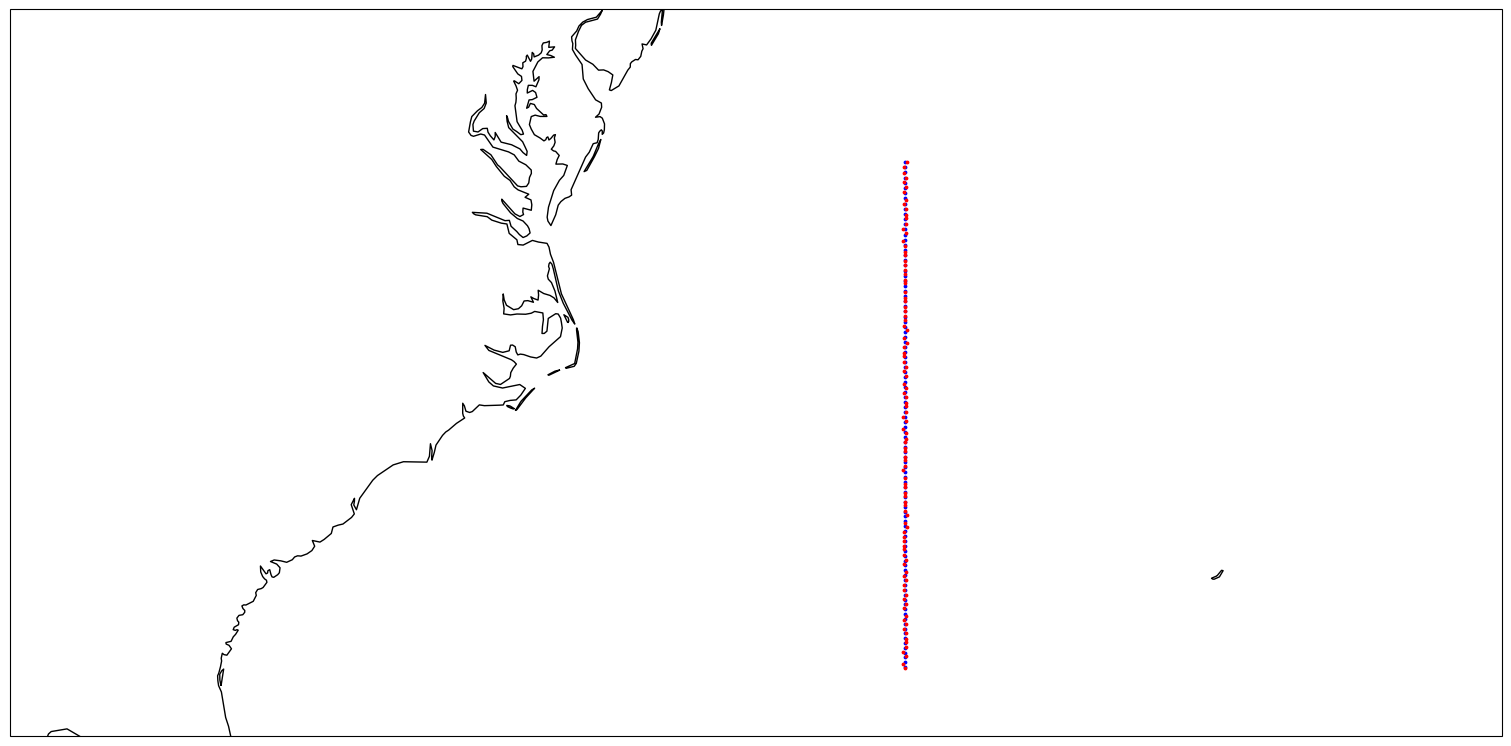

In [13]:
bbox = [-85, -60, 30, 40]
point_size = 3

fig, ax = plt.subplots(
            1,
            1,
            subplot_kw=dict(projection=ccrs.Mercator()),
            constrained_layout=True,
            figsize=(15,10),
        )
ax.set_extent(bbox, crs=ccrs.PlateCarree())
ax.scatter(lonlat[0, :], lonlat[1, :], s=point_size, c="b", transform=ccrs.PlateCarree())
ax.scatter(
        grid["clon"].values[nodes_ocean], grid["clat"].values[nodes_ocean], s=point_size, c="r",
    transform=ccrs.PlateCarree()
    )
ax.coastlines("50m")

Now we can just select the model points by index:

In [19]:
nodes_ocean

array([4964741, 4964739, 4964819, 4964817, 4964815, 4965302, 4965278,
       4965309, 4965319, 4965317, 1809309, 1809308, 1809281, 1809327,
       1809328, 1808715, 1808721, 1808609, 1808602, 1808694, 1808695,
       1808648, 1808652, 1808661, 1809069, 1809070, 1809030, 1809029,
       1809037, 1808870, 1808868, 1809012, 1809010, 1552811, 1552810,
       1552786, 1552789, 1552829, 1552826, 1550514, 1550480, 1550486,
       1550530, 1550533, 1553321, 1553318, 1553190, 1553191, 1553291,
       1553293, 1553245, 1553235, 1553258, 1553154, 1553155, 1553115,
       1553117, 1553122, 1553119, 1552966, 1553096, 1553095, 1553760,
       1553773, 1553747, 1553744, 1553789, 1553788, 1544566, 1544531,
       1544540, 1544582, 1544578, 1544586, 1544171, 1544107, 1544332,
       1544336, 1544286, 1544274, 1544278, 1544303, 1545095, 1545052,
       1545044, 1545056, 1545060, 1545066, 1545067, 1545035, 1542956,
       1542947, 1542960, 1542930, 1542931, 1542939, 1545527, 1545493,
       1545491, 1545

In [23]:
oc_data = data["to"].isel(time=-1, cell=nodes_ocean)

And plot it (here only first 40 levels are plotted)

Text(0, 0.5, 'Depth, m')

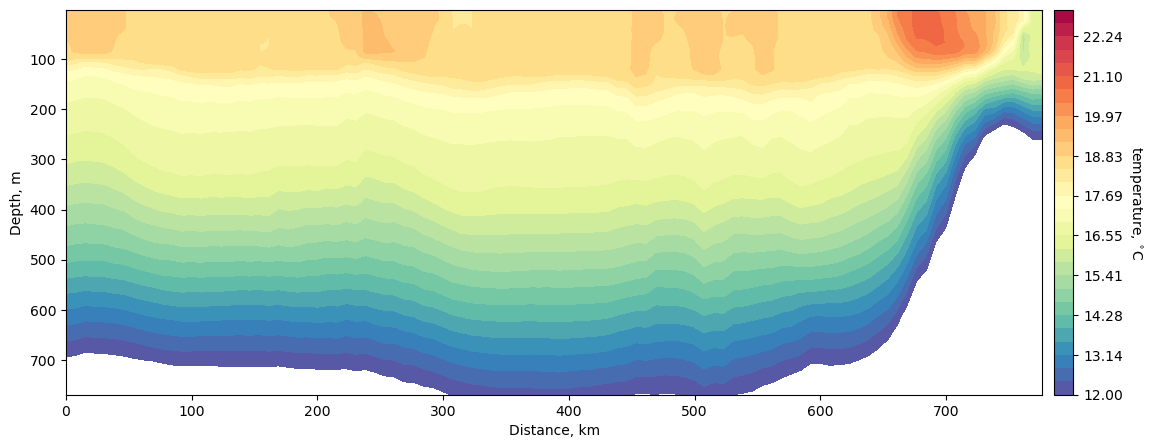

In [27]:
plt.figure(figsize=(15,5))
ax = plt.gca()
im = ax.contourf(dist, data.depth.values[0:40], oc_data[0:40,:], 
                 levels=np.linspace(12,23,30), 
                 cmap=cm.Spectral_r)
ax.invert_yaxis()
cbar = plt.colorbar(im, pad=0.01)
cbar.set_label('temperature, $^{\circ}$C', rotation=270, labelpad=15)
ax.set_xlabel('Distance, km')
ax.set_ylabel('Depth, m')